In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

landscape_image = Image.open('Banff_is_beautiful.jpg')
cat_image = Image.open('king.jpg')
cat_image = cat_image.rotate(-90)
cat_image = cat_image.resize((cat_image.width // 3, cat_image.height // 3))


# Convolution

A convolution (the mathematical function behind "convolutional neural network") is a common mathematical method of combining two signals. Specifically, if $f$ and $g$ are our functions representing signals then the convolution of $f$ and $g$ is given by the integral of the product of $f$ and $g$, calculated after g has been reflected over all axes and shifted over all space:

$$(f∗g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t-\tau) \, dx$$

Or for two discrete functions:

$$(f∗g)|n| = \sum_{-\infty}^{\infty} f(m)g(n-m)$$

Of particular interest when processing images is the 2D discrete convolution:

$$ {\displaystyle x(n_{1},n_{2})*h(n_{1},n_{2})=\sum _{k_{1}=-\infty }^{\infty }\sum _{k_{2}=-\infty }^{\infty }h(k_{1},k_{2})x(n_{1}-k_{1},n_{2}-k_{2})} $$

Where the arguments of the $x$ and $h$ functions can be considered horizontal and vertical coordinates within 2D space. One can think of the $x$ function as being the image itself (it returns the pixel value at every $(n_1, n_2)$ coordinate) and the $h$ function as being the filter that is passed over the image, commonly known as the *kernel*. While the image that we are processing is given, we have control over the kernel, $h$.

While this does add some context to what a convolution is, there are still those pesky infinities to deal with. As a favourite mathematics professor of mine once said, "men have been driven mad by infinities, and we will be no exception." This statement was likely based on the popular, and [discredited](https://en.wikipedia.org/wiki/Georg_Cantor#Biographies), myth that Georg Cantor was driven mad by his work, but I digress. While certain kernels - Gaussian blur, as an example - do theoretically span the entire 2D space (with diminishingly small values), most kernels are much simpler. And even Gaussian blur is approximated by a small matrix in practice. In the case of image processing within convolutional neural networks, it is common to see kernels as small as 3x3. For example, a common kernel used in horizontal edge detection is the vertical Prewitt operator:

$$h(n_1, n_2) = \begin{bmatrix}
1 & 1 & 1\\
0 & 0 & 0\\
-1 & -1 & -1
\end{bmatrix}$$

These kernels are non-zero only for coordinates at the origin or directly adjacent to it. With this simplifying assumption, the 2D discrete convolution formula becomes much more manageable:


$$ {\displaystyle x(n_{1},n_{2})*h(n_{1},n_{2})=\sum _{k_{1}=-1}^{1}\sum _{k_{2}=-1}^{1}h(k_{1},k_{2})x(n_{1}-k_{1},n_{2}-k_{2})} $$

since all elements of the sum where $h(k_{1},k_{2}) = 0$ are multiples of zero, and therefore zero themselves. The limits of $k_{1}$ and $k_{2}$ are often restricted in this way, though it is worth noting that if a kernel larger than the image were to be used, $k_{1}$ and $k_{2}$ would instead be restricted by the size of the processed image.

Understanding this formula is essential to understanding convolutions in practice. Consider, for example, the vertical Prewitt operator given earlier. Why is it useful in horizontal edge detection? Well, from our formula we can see exactly what effect the convolution with the kernel will have on a pixel $(n_1, n_2)$. The intensities of the pixel itself and the pixels next to it are multiplied by zero, meaning that they contribute nothing to the overall sum. The non-zero values are the sum of the three pixels adjacent to and below the origin pixel, minus the sum of the three pixels adjacent to and above the original pixel: 

$$ {\displaystyle x(n_{1},n_{2})*h(n_{1},n_{2})=\sum _{k_{2}=-1}^{1}h(1 ,k_{2})x(n_{1}-1,n_{2}-k_{2})} + \sum _{k_{2}=-1}^{1}h(-1,k_{2})x(n_{1}+1,n_{2}-k_{2})$$
$$ = \sum _{k_{2}=-1}^{1}x(n_{1}+1,n_{2}-k_{2}) - \sum _{k_{2}=-1}^{1}x(n_{1}-1,n_{2}-k_{2}) $$

This difference will determine the intensity of the resulting pixel and is zero exactly where the intensities of all of the pixels below are equal to the intensities of all of the pixels above. That is, where there is no edge. Conversely, the value is maximized (and, therefore, the intensity of the pixel is maximized) exactly where there is a sharp fall-off, or sharp increase, in the intensities of the pixels below and above the origin pixel. Another way of looking at this is that the Prewitt operator is an estimation of the derivative of the intensity along the y-axis. If this isn't clear, the below example using an image of the beautiful Banff, Canada might shed some light (and highlight some lines).


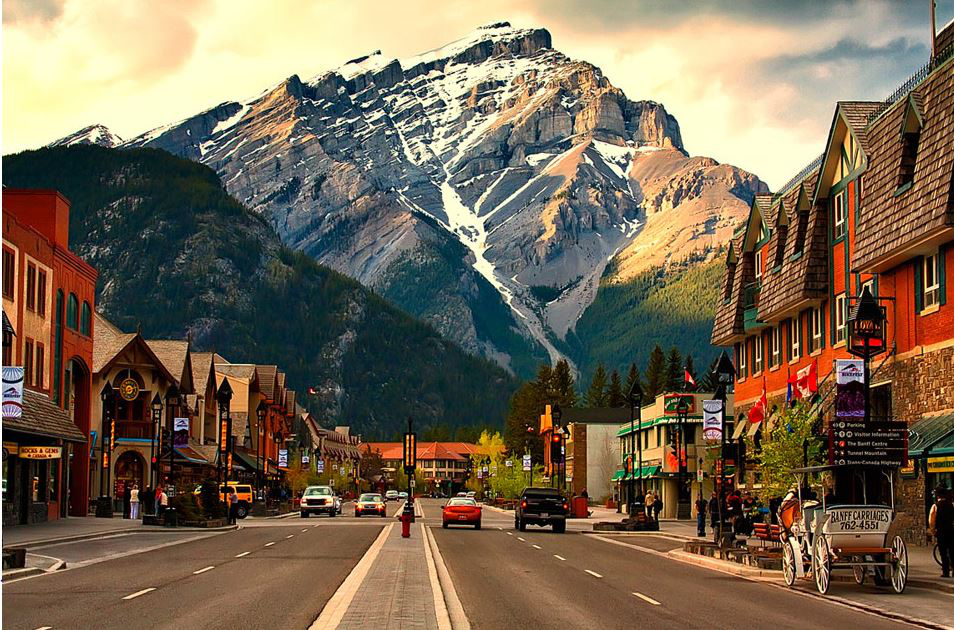

In [12]:
landscape_image

First, I am going to make a useful simplification. I will convert the image to grayscale, so that there is only one colour channel in the image instead of 3.

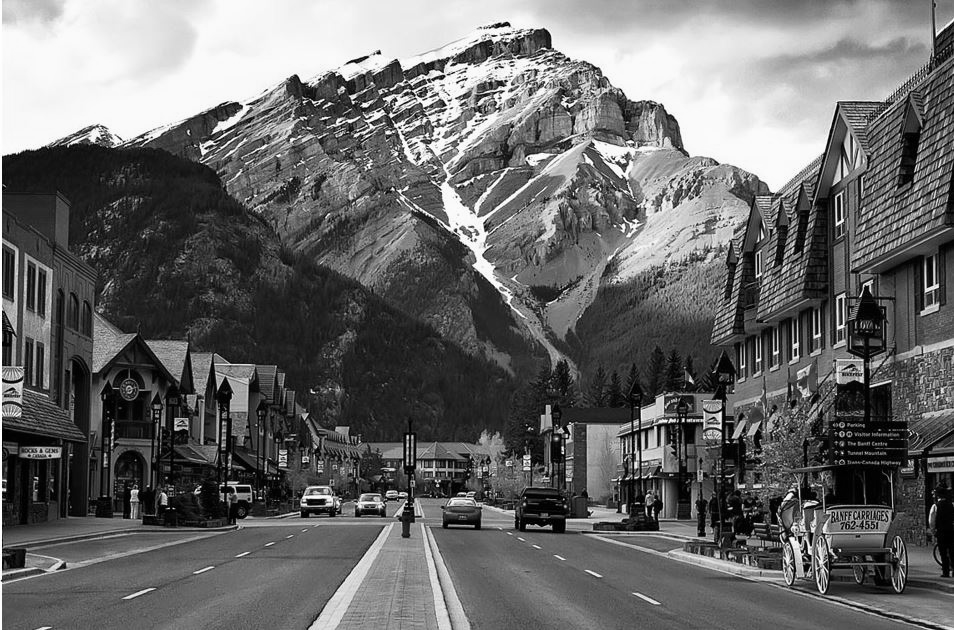

In [13]:
landscape_image_gs = landscape_image.convert('L')
landscape_image_gs

In [14]:
print(np.array(landscape_image).shape)

(630, 954, 3)


In [15]:
print(np.array(landscape_image_gs).shape)

(630, 954)


Now, I want to apply a 2D convolution to the image using the vertical Prewitt kernel. In order to achieve this, I will use scipy's built-in convolve2d function.

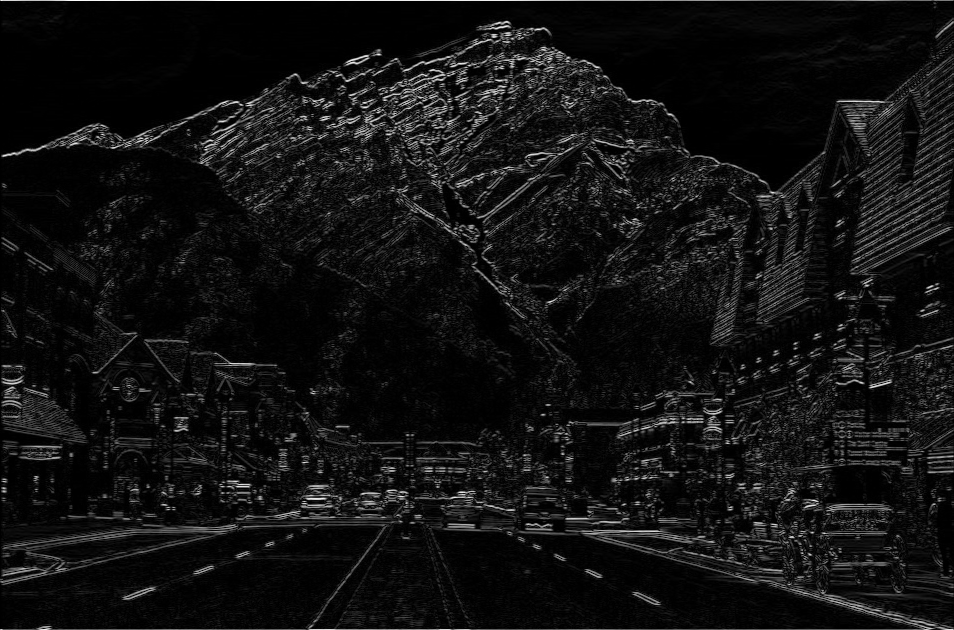

In [16]:
from scipy.signal import convolve2d

image_array = np.array(landscape_image_gs)
vert_prewitt = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

#Applying the convolution
processed_image_array = convolve2d(image_array, vert_prewitt, mode='same')

#Rescaling the pixel values to fit in the 0 to 255 range, the range of intensity values for a grayscale image
processed_image_array = (np.abs(processed_image_array) / processed_image_array.max() * 255).astype('uint8')

processed_image_vpw = Image.fromarray(processed_image_array)

processed_image_vpw

This convolution did exactly what our intuition told us it would. It emphasized edges, with greater intensity corresponding to intensity of edges in the original image and the degree to which they are horizontal. You might notice that even though the line between the street and the central median is distinct in the original image, it is relatively faded in the processed image. This is due to it being mainly vertical. Compare this to the image produced using the *horizontal* Prewitt kernel.

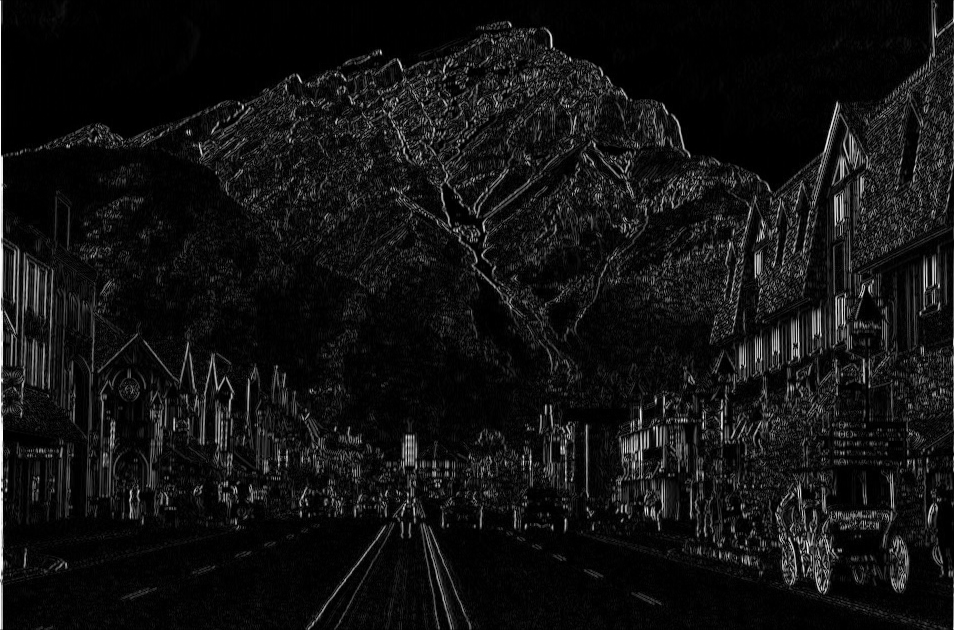

In [17]:
image_array = np.array(landscape_image_gs)
vert_prewitt = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

#Applying the convolution
processed_image_array = convolve2d(image_array, vert_prewitt, mode='same')

#Rescaling the pixel values to fit in the 0 to 255 range, the range of intensity values for a grayscale image
processed_image_array = (np.abs(processed_image_array) / processed_image_array.max() * 255).astype('uint8')

processed_image_hpw = Image.fromarray(processed_image_array)

processed_image_hpw

These edges are much more emphasized. Along with many other vertical edges that were faded in the image convolved with the vertical Prewitt function. These kernels highlight a lot of useful information in certain types of images, but not others. For example, look at how much information is lost when the same two kernels are convolved with an image of my cat sitting like he is people.

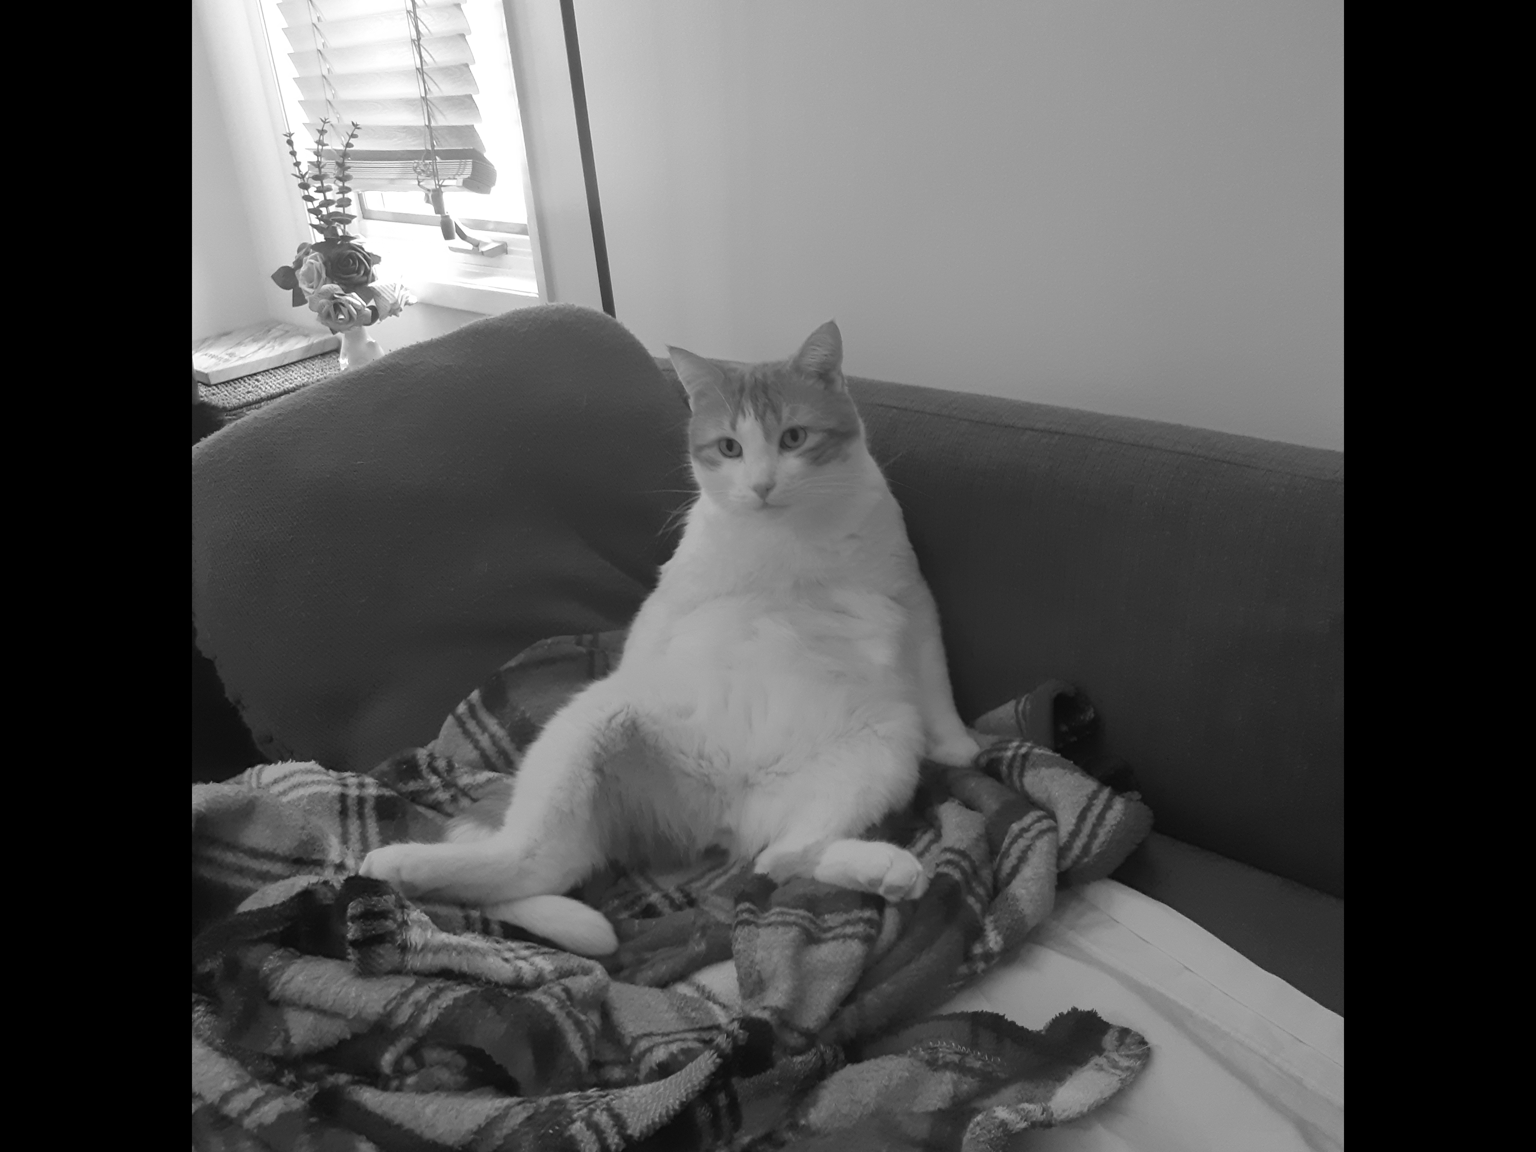

In [18]:
cat_image_gs = cat_image.convert('L')
cat_image_gs

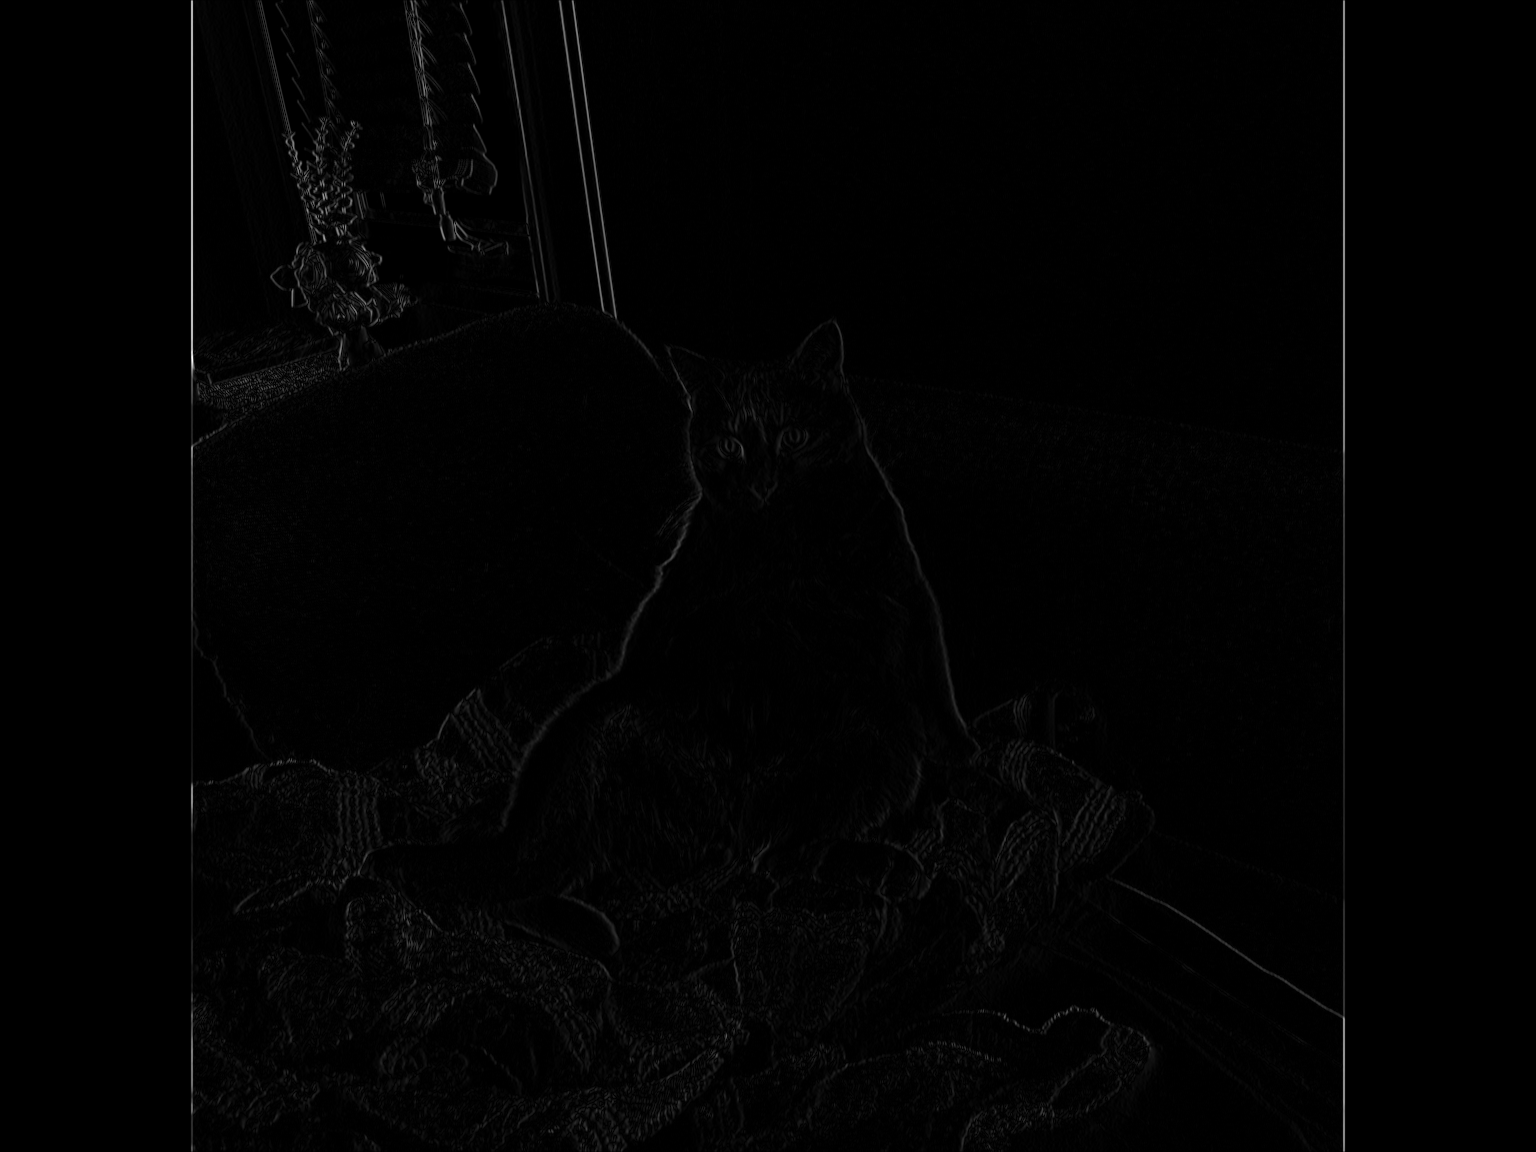

In [19]:
image_array = np.array(cat_image_gs)
vert_prewitt = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

#Applying the convolution
processed_image_array = convolve2d(image_array, vert_prewitt, mode='same')

#Rescaling the pixel values to fit in the 0 to 255 range, the range of intensity values for a grayscale image
processed_image_array = (np.abs(processed_image_array) / processed_image_array.max() * 255).astype('uint8')

processed_image_hpw = Image.fromarray(processed_image_array)

processed_image_hpw

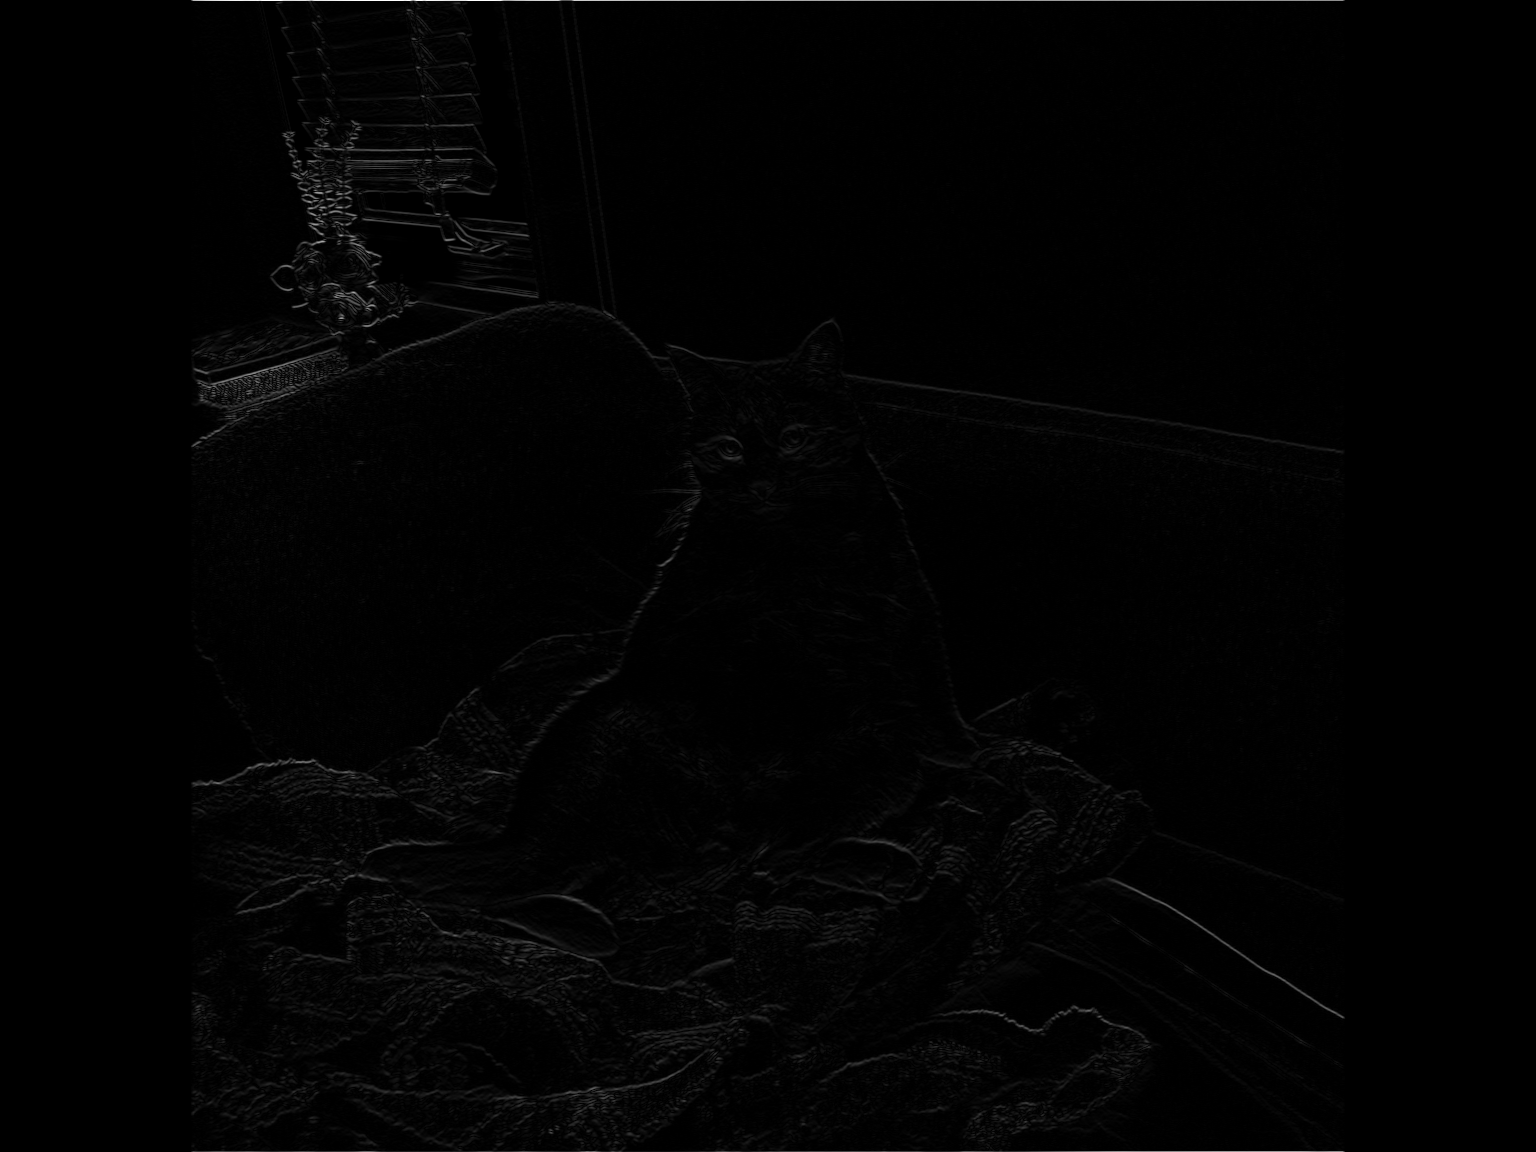

In [20]:
image_array = np.array(cat_image_gs)
vert_prewitt = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

#Applying the convolution
processed_image_array = convolve2d(image_array, vert_prewitt, mode='same')

#Rescaling the pixel values to fit in the 0 to 255 range, the range of intensity values for a grayscale image
processed_image_array = (np.abs(processed_image_array) / processed_image_array.max() * 255).astype('uint8')

processed_image_vpw = Image.fromarray(processed_image_array)

processed_image_vpw

You can see that a lot of information is lost in these convolutions, and for the most part only the outline of the cat is conserved. If the goal of a CNN was to identify tabby cats, this would clearly not be an appropriate kernel for the task. However, we can try different kernels to see what they produce.

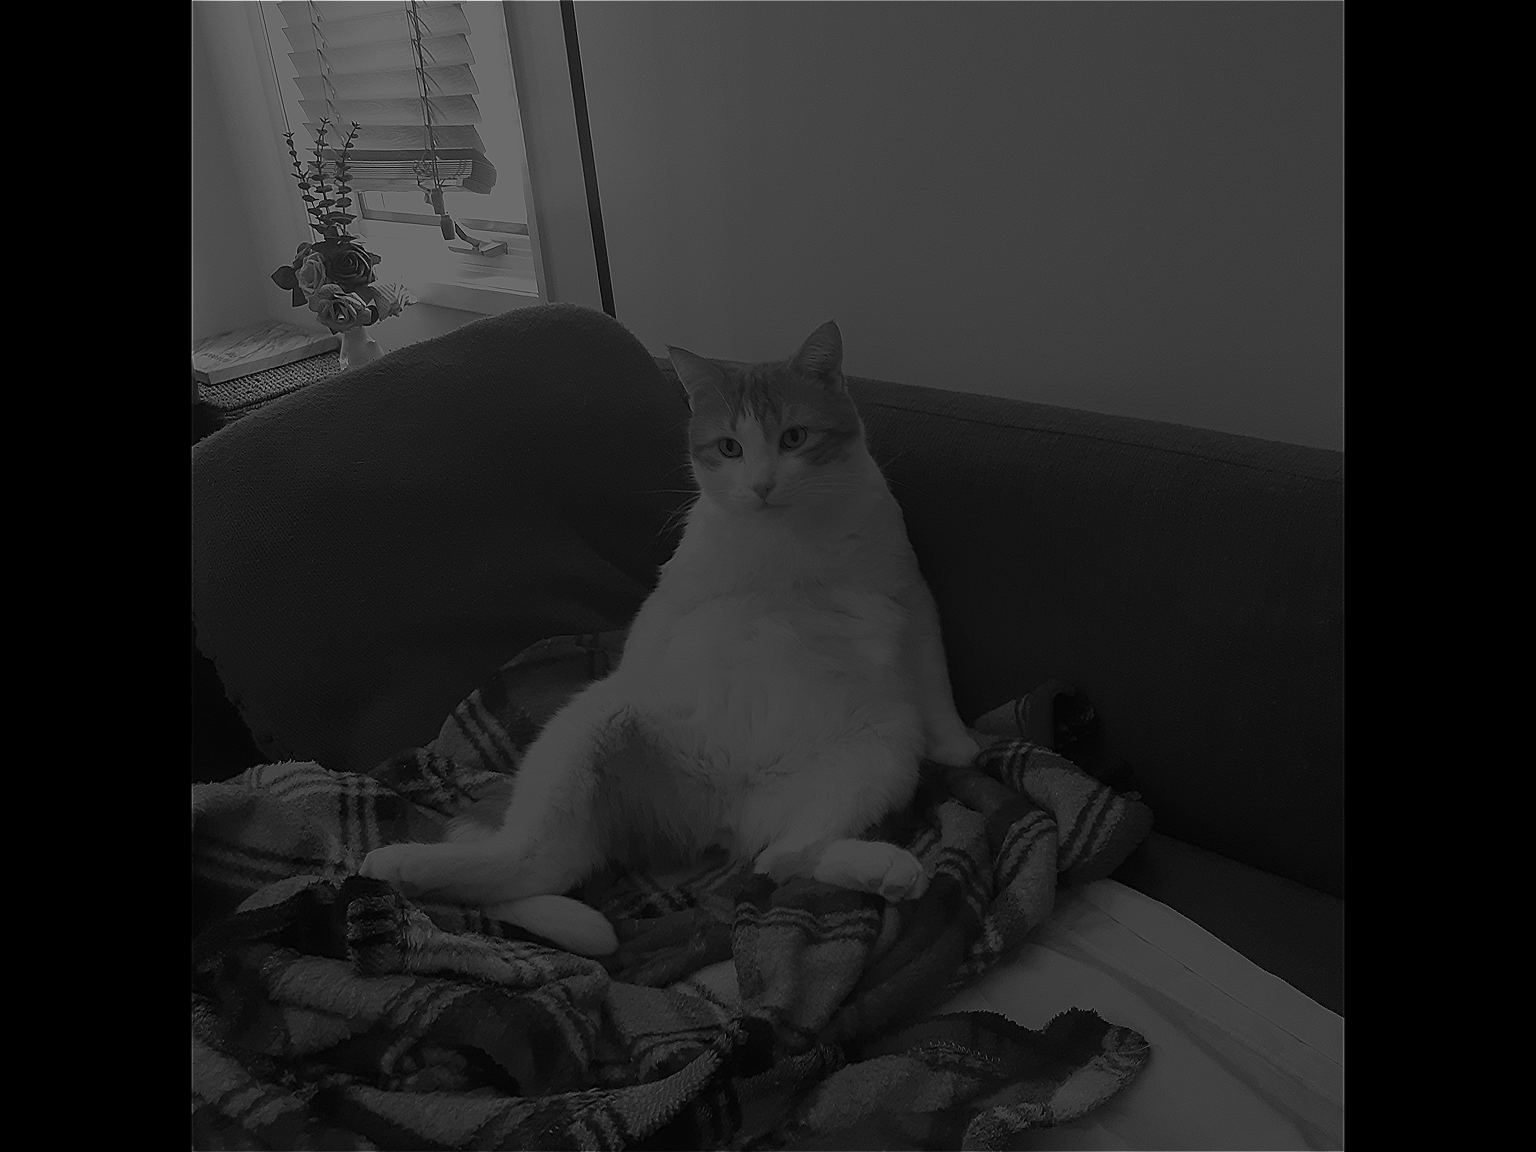

In [21]:
image_array = np.array(cat_image_gs)
vert_prewitt = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

#Applying the convolution
processed_image_array = convolve2d(image_array, vert_prewitt, mode='same')

#Rescaling the pixel values to fit in the 0 to 255 range, the range of intensity values for a grayscale image
processed_image_array = (np.abs(processed_image_array) / processed_image_array.max() * 255).astype('uint8')

processed_image_vpw = Image.fromarray(processed_image_array)

processed_image_vpw

The effect of this kernel is more subtle. It increases the sharpness off the image. Is this a useful kernel to use when processing the image for classification? It is hard to say.

# CNNs

So how do we know what kernel to use for a given classification task? Isn't choosing a good kernel a hyperparametric nightmare? Of course! And that is why the kernel is *learned*, through training, in a neural networks convolutional layers. The values inside the kernel:

$$ w = \begin{bmatrix}
w_1 & w_2 & w_3\\
w_4 & w_5 & w_6\\
w_7 & w_8 & w_9
\end{bmatrix}$$

are exactly the weights that are updated during backpropagation. This allows CNNs to learn kernels that are not entirely intuitive, but potentially useful for the classification task. This process of learning weights through training also allows us to experiment with exotic hyperparameters for the kernel and how it is applied the image. For example, Pytorch's conv2d allows customization of the following:

- __stride:__ The number of pixels that are skipped in the processing of the image. If the stride is 1 then every pixel has a corresponding output from the function (assuming appropriate padding), if the stride is 2 then every second pixel is skipped, etc.
- __dilation:__ Spacing between kernel points. N x N kernels with a padding of m are essentially (N + (N - 1) * m) x (N + (N - 1) * m) kernels with m zeros between each entry of the kernel. The above weight matrix with dilation 1 would become:

$$ w = \begin{bmatrix}
w_1 & 0 & w_2 &  0 & w_3\\
0 & 0 & 0 & 0 & 0 \\
w_4 & 0 & w_5 & 0 & w_6\\
 0 & 0 & 0 & 0 & 0 \\
w_7 & 0 & w_8 & 0 & w_9
\end{bmatrix}$$

It is worth asking what this achieves. After all, a 5x5 kernel could simply learn zeros for all of the in-between weights if that was a useful method of image processing. However, it is difficult to reduce weights to zero using backpropagation. So if there are two usesful kernels that could be learned, and one of them does not require pushing weights arbitrarily close to zero, then the algorithm is likely to settle on the "easier" to learn kernel, even if the kernel with many zero weights would have produced better results. Setting these weights to zero enables (forces) the convolutional layer to learn relationships between pixels that are spatially separated from each other, potentially resulting in the extraction of better features. In practice, this is just a hyperparameter that can be tuned.

It might be interesting to visualize the types of kernels that a convolutional neural network will learn given a specialized dataset. To do so, I will train a ResNet for image classification of cats and dogs, extract a learned kernel in a convolutional layer, and use that kernel to directly process the above image.

A note: the model I am using here is an adaptation of a years-old [repository of mine](https://github.com/tylanoflynn/residual_experiments) which was itself simply a translation of the original LuaTorch ResNet code to PyTorch, before ResNet had officially been added to PyTorch. Since it doesn't add much to the discussion, I will exclude details of building and training the model and simply note that it is a ResNet model trained on the good ol' Dogs vs. Cats dataset found [here](https://www.kaggle.com/competitions/dogs-vs-cats/).

Extracting the first kernel from the first node in the first convolutional layer yields the following:

$$ w = \begin{bmatrix}
0.2076 & 0.1078 & 0.0518 \\
0.0183 & 0.0304 & 0.0150\\
-0.1191 & -0.4422 & -0.0191
\end{bmatrix}$$

This kernel is determined via backpropagation with SGD and is, as expected, not nearly as clean as a hand-crafted kernel like the Prewitt operator. That said, it does actually have some of the qualities of an edge-detection kernel. The middle row is all values near 0 and the upper and lower rows have opposite signs. However, the effect if applying a convolution using this kernel to an image is much less pronounced:

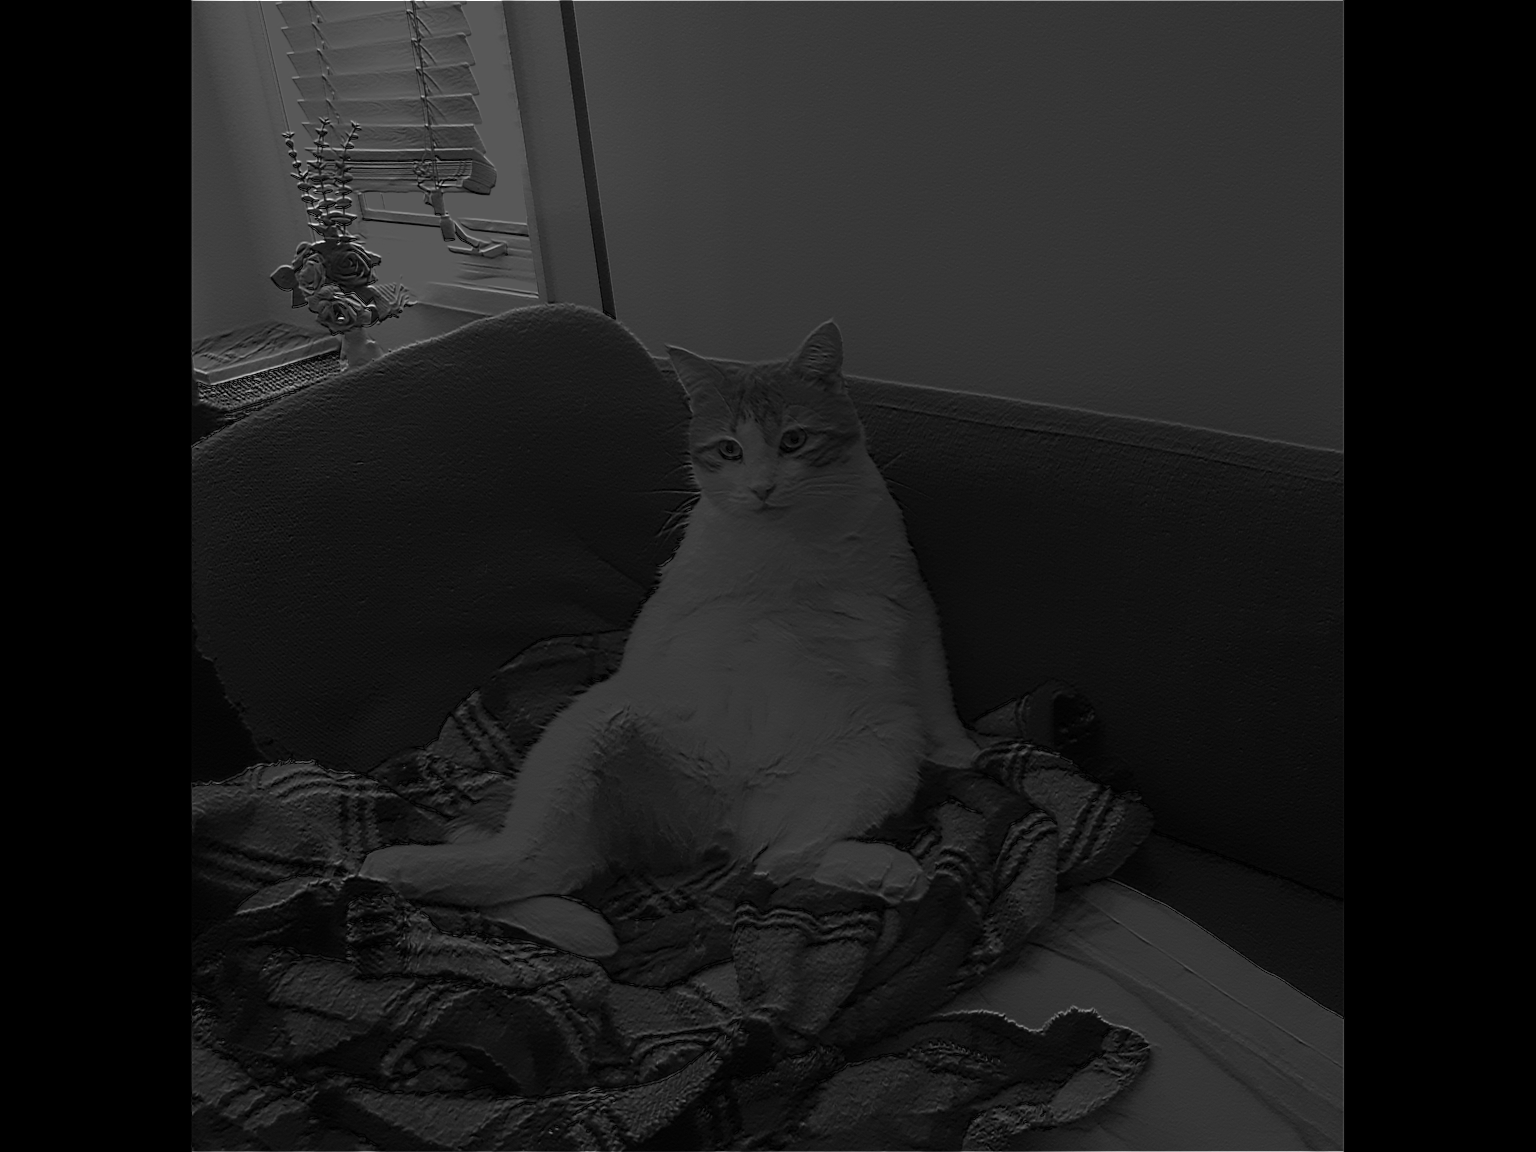

In [32]:
image_array = np.array(cat_image_gs)
vert_prewitt = np.array([[0.2076, 0.1078, 0.0518], [0.0183, 0.0304, 0.0150], [-0.1191, -0.4422, -0.0191]])

#Applying the convolution
processed_image_array = convolve2d(image_array, vert_prewitt, mode='same')

#Rescaling the pixel values to fit in the 0 to 255 range, the range of intensity values for a grayscale image
processed_image_array = (np.abs(processed_image_array) / processed_image_array.max() * 255).astype('uint8')

processed_image_vpw = Image.fromarray(processed_image_array)

processed_image_vpw

In [33]:
print(print(model.Layer1[0].Conv0.weight))

AttributeError: 'ResNet' object has no attribute 'Layer1'

We can see that this image is darker than the original image, and that certain lines - like horizontal whiskers - seem to be slighlty emphasized. If we really stretch our imaginations, we could perhaps claim that this kernel adds emphasis to fur. But the reality is that it is not easy to determine why the model landed on this kernel. We can only say that it led to better classification accuracy during training. Given how many distinct convolutions with distinct kernels occur in just this first layer (16 in my model), it is not impossible that this kernel increased accuracy over the whole cats and dogs dataset by simply highlighting whiskers in a particular orientation, or whiskers that are wider than the animal's body. Or another reason altogether. Perhaps nothing is particularly highlighted in this node, but a later layer's values become more useful due to the image being processed in just this way.


Was this article just an excuse to post a picture of my cat on the internet? Who can say. The nature of all neural networks is that they are difficult to interpret. While visualizations of the convolutions that occur within CNNs can offer us some rare insight into their inner workings, conclusions based on those visualizations are often reductive overly reductive or just flat-out wrong. That said, I hope that you enjoyed my discussion of convolutions and how they are employed in the training of neural networks for image classification.